In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
44571,NaN,NaN,International,2020-09-16,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44572,NaN,NaN,International,2020-09-17,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44573,NaN,NaN,International,2020-09-18,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


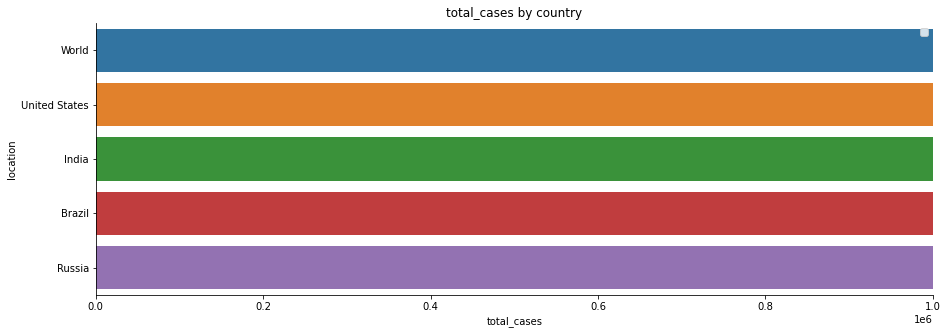

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


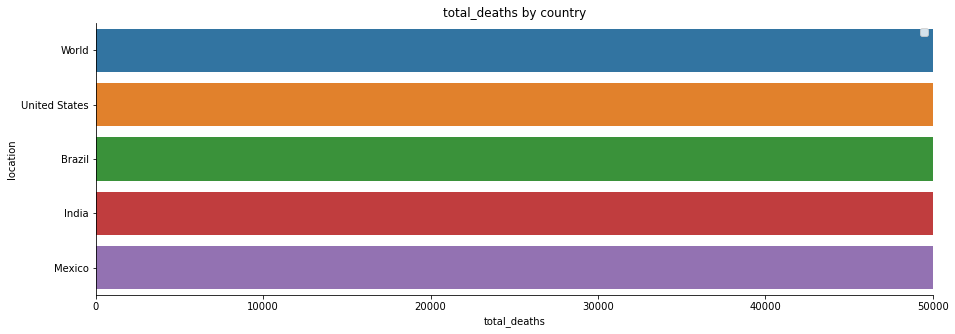

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


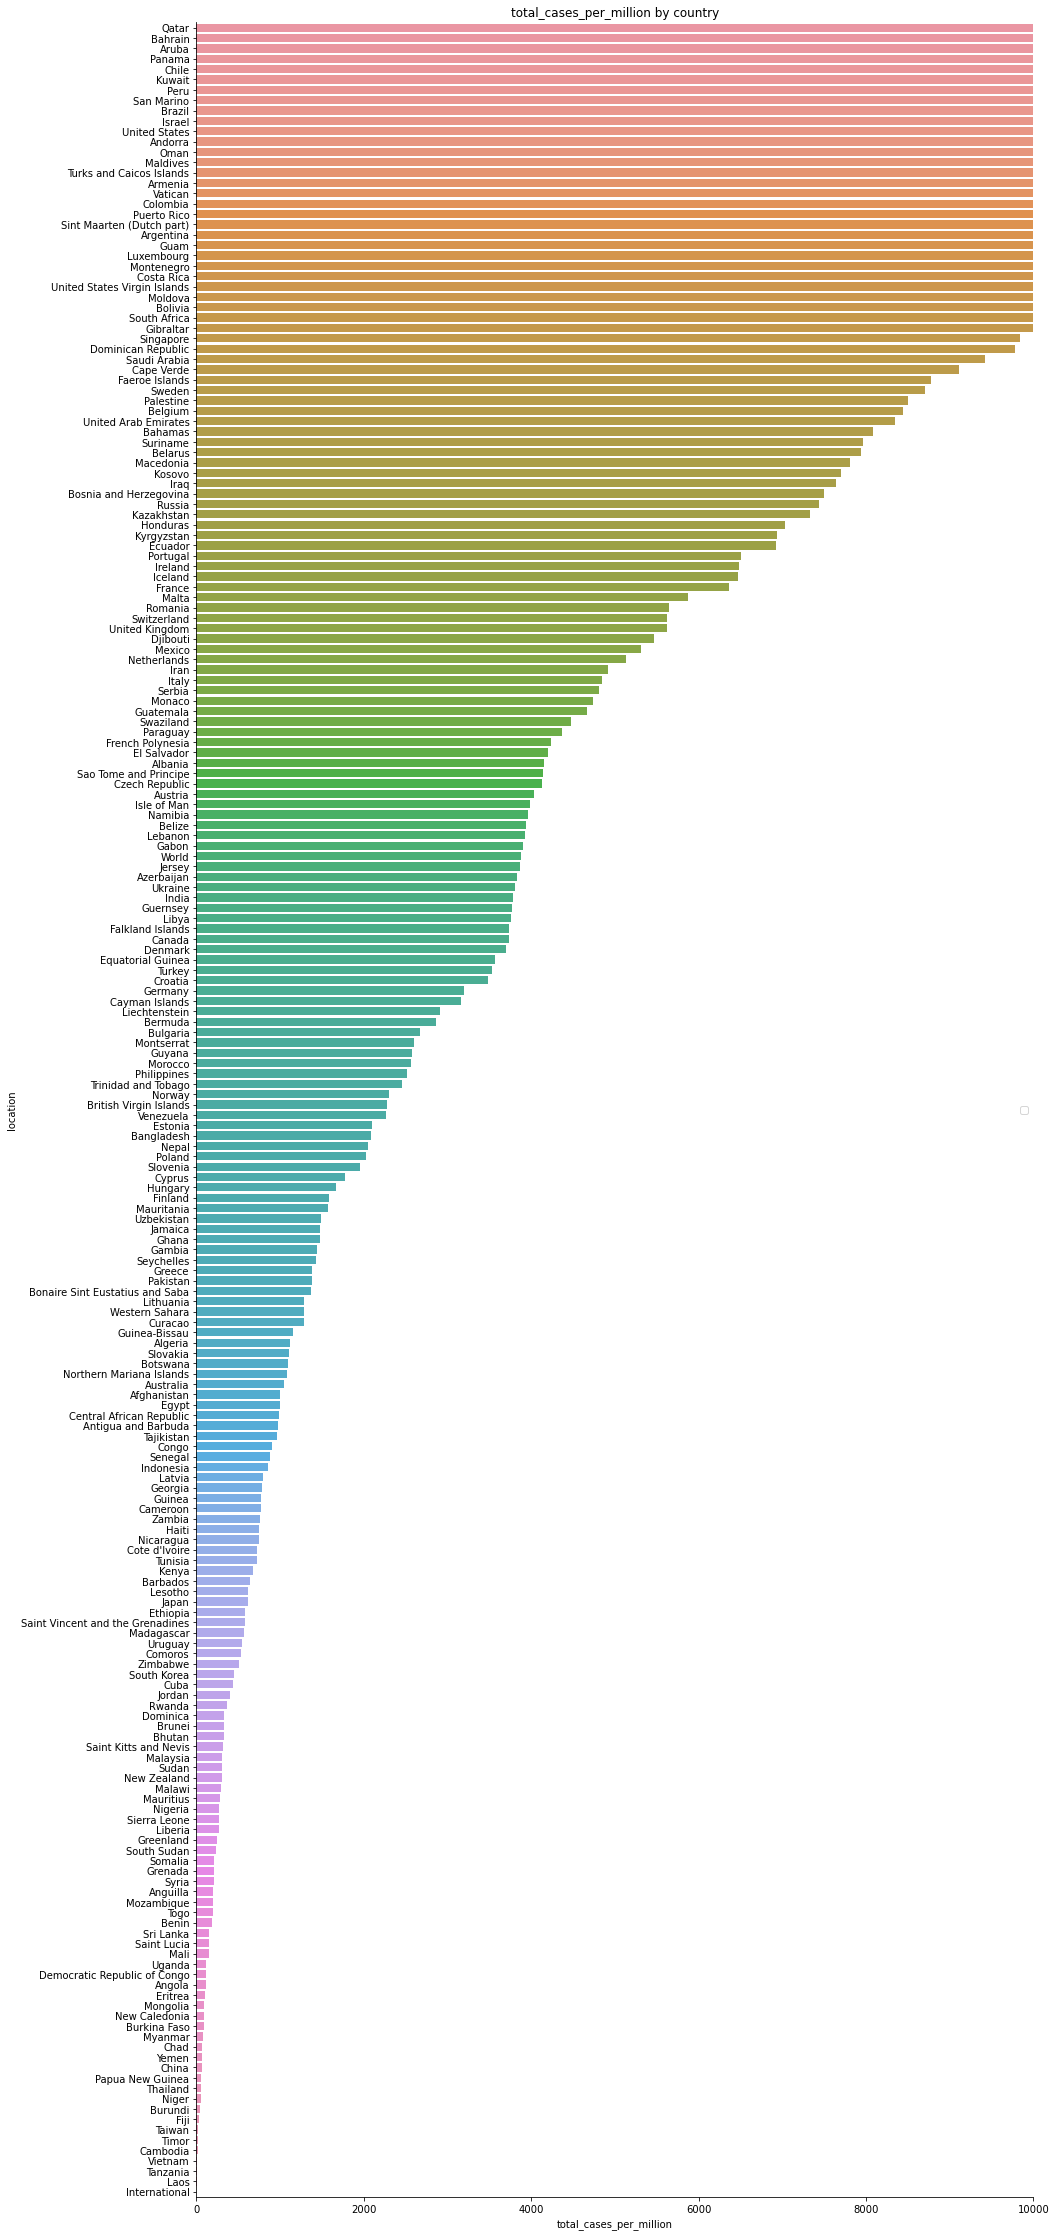

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


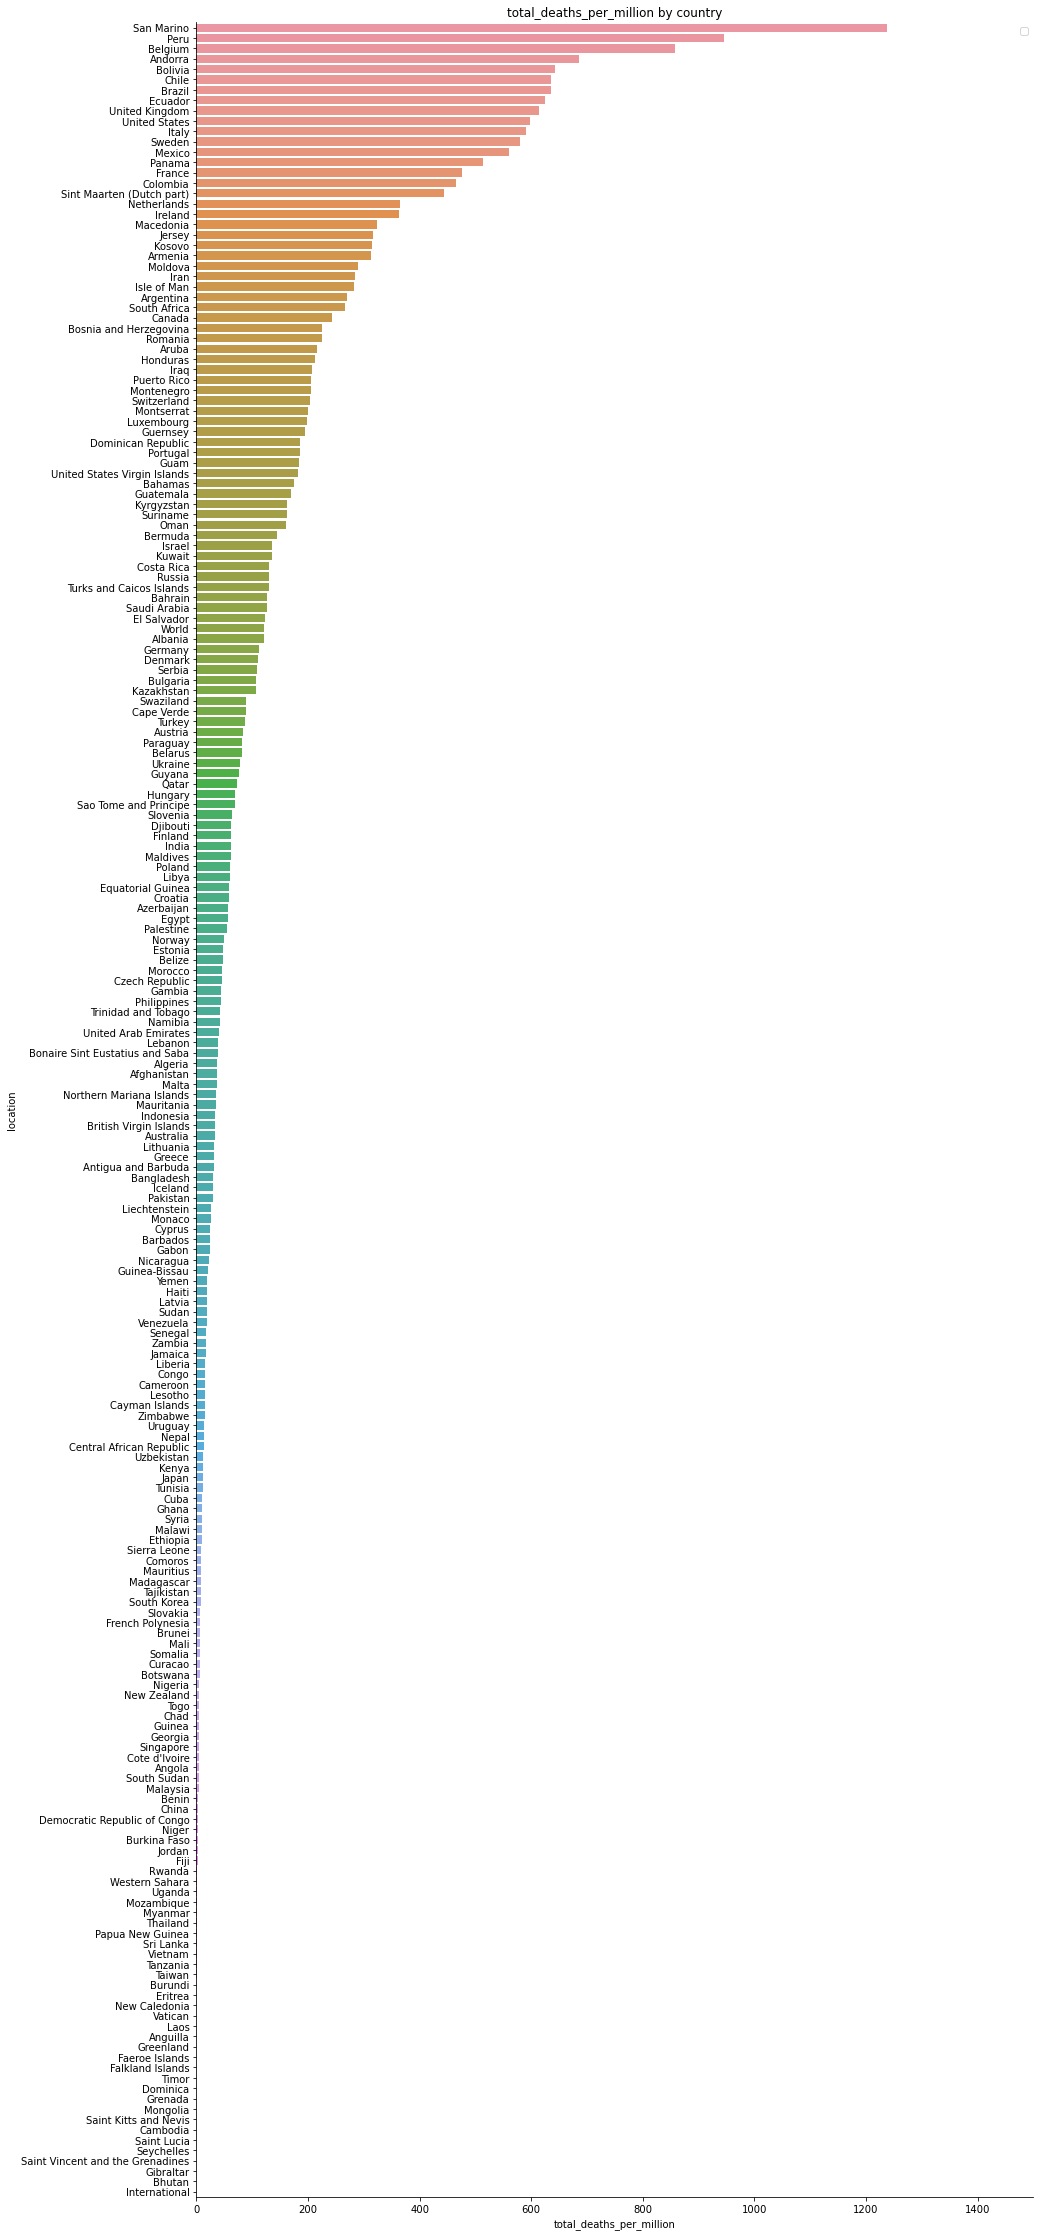

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

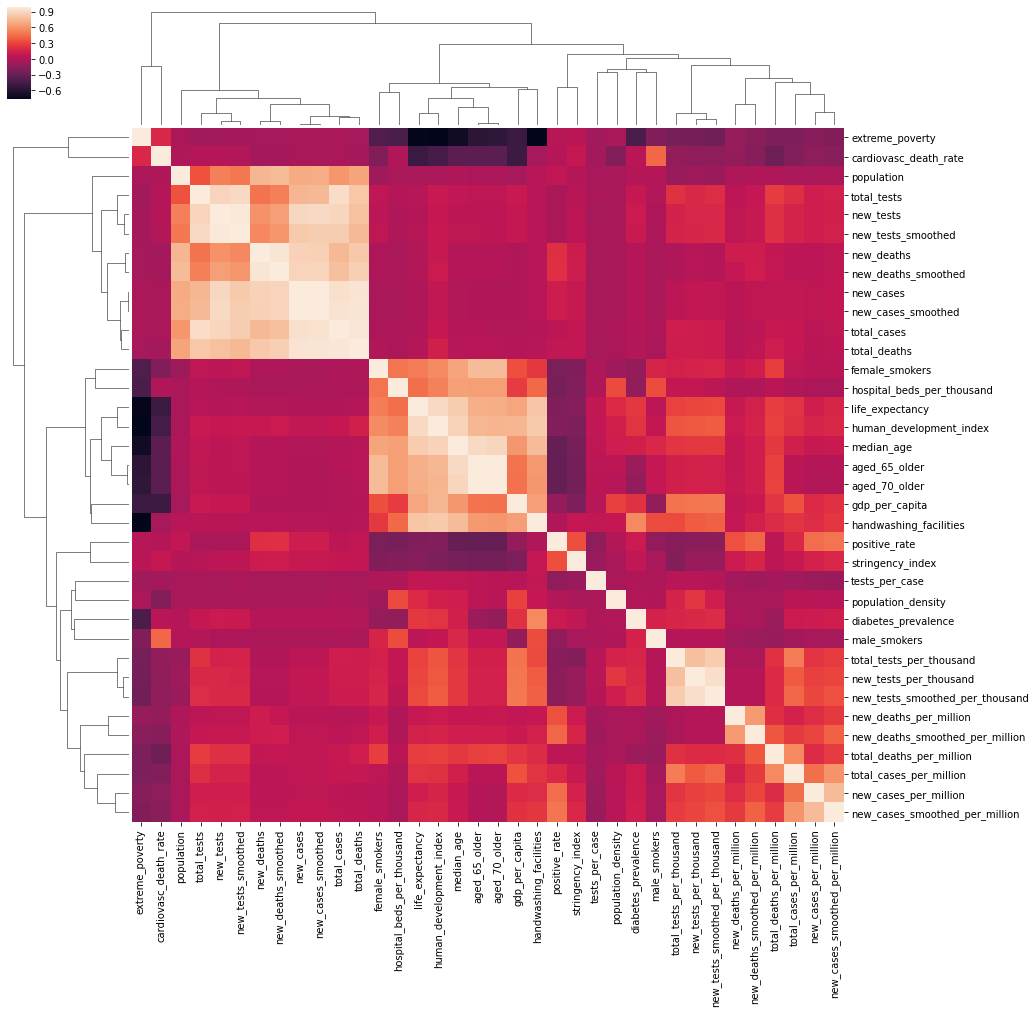

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9987981995515877 (+/- 0.00147658683183787)
Coef :  [1.03245536e+00 8.67359062e-05 8.93499821e-05]
3 Last_days :  [[29625944 29916116 30214496]]
Today :  30214496
Prediction + :  478662
Tomorow :  30693158
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996864149518726 (+/- 0.00010825028863814335)
Coef :  [0.19096845 0.39782428 0.42137965]
3 Last_days :  [[936023 941458 946665]]
Today :  946665
Prediction + :  8702
Tomorow :  955367
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8911343722081062 (+/- 0.15007751892248108)
Coef :  [-0.75490195  0.78806006  0.97144483]
3 Last_days :  [[395104 404888 415481]]
Today :  415481
Prediction + :  8911
Tomorow :  424392
                                     
--------- Total Death -----------------
                                     
R^2: 0.9551165008704333 (+/- 0.05523098341587915)
Coef :  [-0.74782439  0.78839871  0.95839714]
3 Last_days :  [[30999 31045 31095]]
Today :  31095
Prediction + :  53
Tomorow :  31148
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9516738577186254 (+/- 0.04481422107036944)
Coef :  [-0.32901499 -0.01200562  1.33528698]
3 Last_days :  [[90243 90250 90294]]
Today :  90294
Prediction + :  27
Tomorow :  90321
                                     
--------- Total Death -----------------
                                     
R^2: -78.59014716864813 (+/- 112.45621305431648)
Coef :  [-0.07750477  0.01247197  1.05677812]
3 Last_days :  [[4736 4736 4736]]
Today :  4736
Prediction + :  5
Tomorow :  4741
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9743824103270486 (+/- 0.035251775796430275)
Coef :  [-0.81455212  0.89373278  0.92022489]
3 Last_days :  [[289990 291442 293025]]
Today :  293025
Prediction + :  1282
Tomorow :  294307
                                     
--------- Total Death -----------------
                                     
R^2: 0.7934532352330478 (+/- 0.26991506449695774)
Coef :  [-0.821601    0.89619874  0.92442293]
3 Last_days :  [[35633 35645 35658]]
Today :  35658
Prediction + :  29
Tomorow :  35687
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.6641540804837823 (+/- 0.46734425949075464)
Coef :  [-0.31813376  0.17379082  1.15083936]
3 Last_days :  [[603167 614360 625651]]
Today :  625651
Prediction + :  9370
Tomorow :  635021
                                     
--------- Total Death -----------------
                                     
R^2: 0.39944707977679145 (+/- 0.5587628366120366)
Coef :  [-0.73018727  0.6402104   1.08906422]
3 Last_days :  [[30004 30243 30405]]
Today :  30405
Prediction + :  199
Tomorow :  30604
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9866307314144683 (+/- 0.01768149844701821)
Coef :  [0.09953078 0.45168275 0.46151406]
3 Last_days :  [[6606293 6630891 6674458]]
Today :  6674458
Prediction + :  75777
Tomorow :  6750235
                                     
--------- Total Death -----------------
                                     
R^2: 0.9986843818100812 (+/- 0.000654598001642685)
Coef :  [-0.42390114  0.68024621  0.7464371 ]
3 Last_days :  [[195937 196802 197633]]
Today :  197633
Prediction + :  1126
Tomorow :  198759
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9780143363516586 (+/- 0.030500732830853118)
Coef :  [-0.67821989  0.82651794  0.85246987]
3 Last_days :  [[374228 378219 381614]]
Today :  381614
Prediction + :  3076
Tomorow :  384690
                                     
--------- Total Death -----------------
                                     
R^2: 0.28688787973124596 (+/- 0.9662862270291437)
Coef :  [-0.76565486  0.83037602  0.93455227]
3 Last_days :  [[41664 41684 41705]]
Today :  41705
Prediction + :  48
Tomorow :  41753
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9822444915497345 (+/- 0.024199802021593685)
Coef :  [-0.78043234  0.84986606  0.93049471]
3 Last_days :  [[263663 265857 267773]]
Today :  267773
Prediction + :  1878
Tomorow :  269651
                                     
--------- Total Death -----------------
                                     
R^2: 0.2953176785905547 (+/- 0.9857728258014428)
Coef :  [-0.78508004  0.8393194   0.94498087]
3 Last_days :  [[9368 9371 9378]]
Today :  9378
Prediction + :  8
Tomorow :  9386
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.7838629287978054 (+/- 0.3037996918823903)
Coef :  [0.31380815 0.35019654 0.34669846]
3 Last_days :  [[407353 410334 413149]]
Today :  413149
Prediction + :  3205
Tomorow :  416354
                                     
--------- Total Death -----------------
                                     
R^2: 0.9659942464394571 (+/- 0.04748387395560245)
Coef :  [0.10799078 0.4571755  0.44567237]
3 Last_days :  [[23453 23632 23808]]
Today :  23808
Prediction + :  206
Tomorow :  24014
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9995622144021095 (+/- 0.00036594078597945)
Coef :  [-0.65394518  0.81070886  0.84064984]
3 Last_days :  [[294620 296391 298039]]
Today :  298039
Prediction + :  1377
Tomorow :  299416
                                     
--------- Total Death -----------------
                                     
R^2: 0.9993352625584689 (+/- 0.0004640100137429423)
Coef :  [-0.81455362  0.89437804  0.91820925]
3 Last_days :  [[7186 7249 7315]]
Today :  7315
Prediction + :  50
Tomorow :  7365
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9837825275566406 (+/- 0.01775818218356503)
Coef :  [-0.1470723   0.52010709  0.63953338]
3 Last_days :  [[4382263 4419083 4455386]]
Today :  4455386
Prediction + :  55820
Tomorow :  4511206
                                     
--------- Total Death -----------------
                                     
R^2: 0.47191337797812344 (+/- 0.7412982170181576)
Coef :  [-0.05313179  0.49651639  0.56729349]
3 Last_days :  [[133119 134106 134935]]
Today :  134935
Prediction + :  1447
Tomorow :  136382
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(30214496, 946665, 30693158, 955367),
 (415481, 31095, 424392, 31148),
 (293025, 35658, 294307, 35687),
 (625651, 30405, 635021, 30604),
 (6674458, 197633, 6750235, 198759),
 (90294, 4736, 90321, 4741),
 (381614, 41705, 384690, 41753),
 (267773, 9378, 269651, 9386),
 (413149, 23808, 416354, 24014),
 (298039, 7315, 299416, 7365),
 (4455386, 134935, 4511206, 136382)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-09-18,France,424392.0,0.0,31148.0,0.0,0.0,0.0
0,2020-09-18,China,90321.0,0.0,4741.0,0.0,0.0,0.0
0,2020-09-18,Italy,294307.0,0.0,35687.0,0.0,0.0,0.0
0,2020-09-18,Spain,635021.0,0.0,30604.0,0.0,0.0,0.0
0,2020-09-18,United States,6750235.0,0.0,198759.0,0.0,0.0,0.0
0,2020-09-18,World,30693158.0,0.0,955367.0,0.0,0.0,0.0
0,2020-09-18,United Kingdom,384690.0,0.0,41753.0,0.0,0.0,0.0
0,2020-09-18,Germany,269651.0,0.0,9386.0,0.0,0.0,0.0
0,2020-09-18,Iran,416354.0,0.0,24014.0,0.0,0.0,0.0
0,2020-09-18,Turkey,299416.0,0.0,7365.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")